## Working with GeoJSON

In the 3.0 release of pandapower, significant changes have been made to how geospatial data is stored in the net object. Previously, geospatial data was stored in the *line_geodata* and *bus_geodata* tables. However, this structure caused several problems:

- In what projection are the data points stored?
- What do x and y represent? Does x represent latitude, longitude or something else?
- Copmatibility issues with frontend services and QGIS

To resolve this ambiguity, all geospatial data has now been moved to the line and bus tables under the *geo* column. The geometries are stored as GeoJSON objects. [GeoJSON](https://datatracker.ietf.org/doc/html/rfc7946) is a widely used standard for geospatial data, supporting points, lines, and polygons in a unified format with explicit projection definitions.

In [1]:
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
pd.set_option("display.max_colwidth", 120)

In [2]:
net = pn.mv_oberrhein()

In [3]:
print(net.line.geo.head(), "\n")
print(net.bus.geo.head())

0    {"coordinates": [[7.8947079593416, 48.40549007606241], [7.896048283667894, 48.41060722903666], [7.896173712216692, 4...
1    {"coordinates": [[7.8947079593416, 48.40549007606241], [7.892690190852129, 48.40551636934287], [7.887502065342014, 4...
2      {"coordinates": [[7.8947079593416, 48.40549007606241], [7.895064345442788, 48.40360449047714]], "type": "LineString"}
3     {"coordinates": [[7.895064345442788, 48.40360449047714], [7.89613191775149, 48.39796660294922]], "type": "LineString"}
4    {"coordinates": [[7.89613191775149, 48.39796660294922], [7.897077173332039, 48.39788292247765], [7.9009358501319475,...
Name: geo, dtype: object 

0    {"coordinates": [7.765225672614365, 48.41091584192147], "type": "Point"}
1    {"coordinates": [7.778809539550178, 48.40987064550492], "type": "Point"}
2     {"coordinates": [7.779195765893586, 48.4120381144602], "type": "Point"}
3    {"coordinates": [7.775204689771646, 48.40610336882051], "type": "Point"}
4      {"coordinates": [7.7660648474

To make working with these new geospatial data easier and more efficient, a pandas series accessor has been introduced. This accessor allows direct interaction with GeoJSON data and integrates functions provided by GeoSeries in geopandas.

In [4]:
from shapely.geometry import shape, Point, Polygon
from geopandas import GeoSeries
from pandapower.plotting import simple_plotly, create_line_trace, create_bus_trace
import plotly.graph_objects as go

Create a reference point and a polygon to check what elements are inside a certain radius. 

In [5]:
reference_point = (7.781067, 48.389774)
radius_m = 2200
circle_polygon = GeoSeries([Point(reference_point)], crs=4326).to_crs(epsg=31467).buffer(radius_m).to_crs(epsg=4326).iloc[0]

Access the GeoJSON accessor and the needed GeoSeries methods.

In [6]:
lines_intersect = net.line[net.line.geo.geojson.intersects(circle_polygon)].index
buses_within = net.bus[net.bus.geo.geojson.within(circle_polygon)].index
net.line.geo.geojson.total_bounds

array([ 7.74426069, 48.32845845,  7.93829196, 48.47484423])

And plot the results

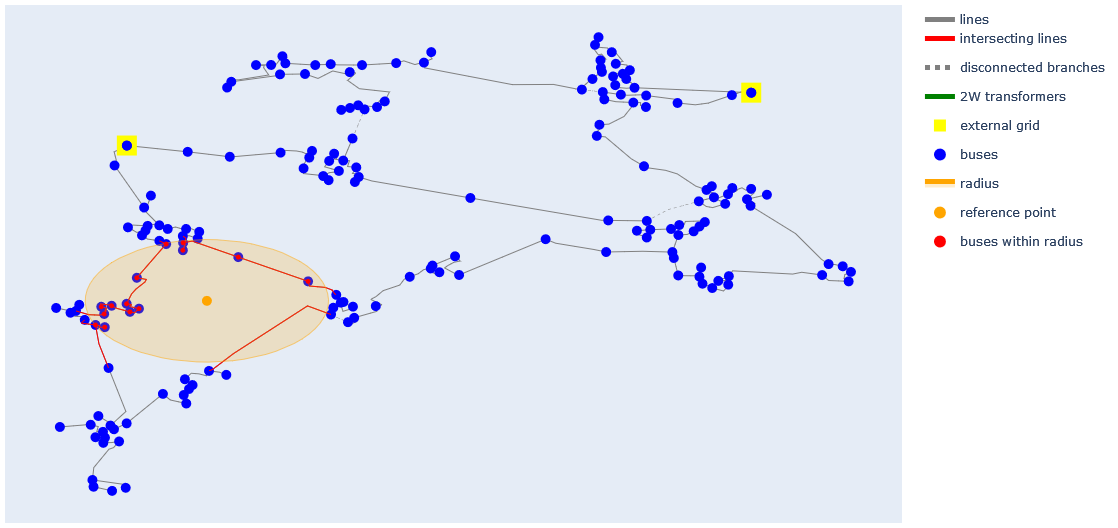

In [7]:
x, y = circle_polygon.exterior.xy
polygon_trace = go.Scatter(
    x=list(x), 
    y=list(y), 
    fill="toself",
    mode="lines",
    line=dict(color="orange", width=0.5),
    fillcolor="rgba(255, 165, 0, 0.2)",
    name="radius"
)

point_trace = go.Scatter(
    x=[circle_polygon.centroid.x], 
    y=[circle_polygon.centroid.y], 
    mode="markers",
    marker=dict(color="orange", size=10),
    name="reference point"
)
lt = create_line_trace(net, lines=lines_intersect, color="red", trace_name='intersecting lines')
bt = create_bus_trace(net, buses=buses_within, color="red", trace_name="buses within radius")
fig = simple_plotly(net, auto_open=False, additional_traces=lt)
fig.add_trace(polygon_trace)
fig.add_trace(point_trace)
fig.add_trace(bt[0])

It is also possible to load the GeoJSON, or view the geo column as GeoSeries or a Series with shapely objects.

In [8]:
net.bus.geo.head() # entries are strings

0    {"coordinates": [7.765225672614365, 48.41091584192147], "type": "Point"}
1    {"coordinates": [7.778809539550178, 48.40987064550492], "type": "Point"}
2     {"coordinates": [7.779195765893586, 48.4120381144602], "type": "Point"}
3    {"coordinates": [7.775204689771646, 48.40610336882051], "type": "Point"}
4      {"coordinates": [7.76606484746611, 48.4124244421834], "type": "Point"}
Name: geo, dtype: object

In [9]:
net.bus.geo.geojson.as_geo_obj.head() # entries are dicts

0    {'type': 'Point', 'coordinates': [7.76522567, 48.41091584]}
1    {'type': 'Point', 'coordinates': [7.77880954, 48.40987065]}
2    {'type': 'Point', 'coordinates': [7.77919577, 48.41203811]}
3    {'type': 'Point', 'coordinates': [7.77520469, 48.40610337]}
4    {'type': 'Point', 'coordinates': [7.76606485, 48.41242444]}
Name: geo, dtype: object

In [10]:
net.bus.geo.geojson.as_geoseries.head() # GeoSeries 

0    POINT (7.76523 48.41092)
1    POINT (7.77881 48.40987)
2     POINT (7.7792 48.41204)
3      POINT (7.7752 48.4061)
4    POINT (7.76606 48.41242)
dtype: geometry

In [11]:
net.bus.geo.geojson.as_shapely_obj.head() # pandas Series with shapely objects

0    POINT (7.765225672614365 48.41091584192147)
1    POINT (7.778809539550178 48.40987064550492)
2     POINT (7.779195765893586 48.4120381144602)
3    POINT (7.775204689771646 48.40610336882051)
4      POINT (7.76606484746611 48.4124244421834)
Name: geo, dtype: object

It is also possible to get the coordinates or the geometry type from the GeoJSON. 
**Note that it is not recommended to use ._coords in applications, because the projection definition is lost!**

In [12]:
net.bus.geo.geojson._coords.head()

0    [7.76522567, 48.41091584]
1    [7.77880954, 48.40987065]
2    [7.77919577, 48.41203811]
3    [7.77520469, 48.40610337]
4    [7.76606485, 48.41242444]
Name: geo, dtype: object

In [13]:
net.bus.geo.geojson.type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
Name: geo, dtype: object